In [1]:
import os.path
import pandas as pd
import geopandas as gpd
from libpysal.weights import Rook
from esda.moran import Moran_Local
from splot._viz_esda_mpl import lisa_cluster

In [2]:
data_dir = "./data"

In [3]:
region_file = os.path.join(data_dir, 'districts-generalized.gpkg')
gdf = gpd.read_file(region_file)
gdf = gdf[gdf.geometry!=None]

In [4]:
timeseries_file = os.path.join(data_dir, 'covid-timeline.csv')
cov_df = pd.read_csv(timeseries_file, delimiter=';', parse_dates=True)
cov_df = cov_df[cov_df.Time=='18.11.2020 00:00:00']
cov_df['GKZ'] = cov_df['GKZ'].astype(int)

<AxesSubplot:>

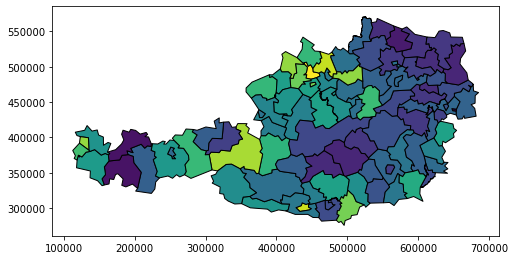

In [5]:
joined = cov_df.set_index('GKZ').join(gdf.set_index('GKZ'), rsuffix='g')
joined['cases_per_100k'] = joined['AnzahlFaelle'] / (joined['AnzEinwohner']/100000)
joined_gdf = gpd.GeoDataFrame(joined)
joined_gdf.plot(column='cases_per_100k', edgecolor='black', figsize=(8,8))

In [6]:
w = Rook.from_dataframe(joined_gdf)

In [7]:
y = joined_gdf['cases_per_100k']

In [8]:
moran_loc = Moran_Local(y, w)

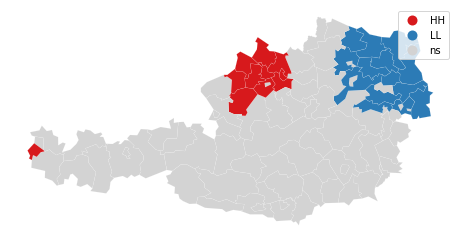

In [9]:
f, ax = lisa_cluster(moran_loc, joined_gdf, figsize=(8,8))